In [1]:
import numpy as np 
import pandas as pd 
import os
import tensorflow as tf

from glob import glob
from tqdm import tqdm

import matplotlib.pyplot as plt
from PIL import Image

In [2]:
X = []
Y = []

for i in tqdm(glob('/kaggle/input/mrl-dataset/train/Open_Eyes/*')):
    temp = np.array(Image.open(i).resize((64,64)))
    X.append(temp)
    Y.append(1)
    
for i in tqdm(glob('/kaggle/input/mrl-dataset/train/Closed_Eyes/*')):
    temp = np.array(Image.open(i).resize((64,64)))
    X.append(temp)
    Y.append(0)    




100%|██████████| 2000/2000 [00:06<00:00, 313.28it/s]


In [3]:
X = np.array(X)
X = X/255.0
Y = np.array(Y)

In [4]:
X = np.expand_dims(X,-1)

In [5]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Conv2D, BatchNormalization, MaxPooling2D,Dropout, Flatten

model = tf.keras.models.Sequential([
      Input(shape=(64, 64, 1)),

      Conv2D(filters = 32, kernel_size = 5, strides = 1, activation = 'relu'),
      Conv2D(filters = 32, kernel_size = 5, strides = 1, activation = 'relu', use_bias=False),
      BatchNormalization(),
      MaxPooling2D(strides = 2),
      Dropout(0.3),

      Conv2D(filters = 64, kernel_size = 3, strides = 1, activation = 'relu'),
      Conv2D(filters = 64, kernel_size = 3, strides = 1, activation = 'relu', use_bias=False),
      BatchNormalization(),
      MaxPooling2D(strides = 2),
      Dropout(0.3),

      Flatten(),
      Dense(units  = 256, activation = 'relu', use_bias=False),
      BatchNormalization(),

      Dense(units = 128, use_bias=False, activation = 'relu'),

      Dense(units = 84, use_bias=False, activation = 'relu'),
      BatchNormalization(),
      Dropout(0.3),

      Dense(units = 1, activation = 'sigmoid')
  ])

2023-01-26 00:54:22.628606: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-26 00:54:22.730730: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-26 00:54:22.731542: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-26 00:54:22.733385: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [7]:
model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])

In [8]:
callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='bestModel.h5',
    save_weights_only=False,
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    verbose =1)
model.fit(x_train, y_train, validation_split=0.2, epochs=30, batch_size=32, callbacks=callback)

2023-01-26 00:54:25.878160: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/30


2023-01-26 00:54:27.814752: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


67/67 [==============================] - 9s 12ms/step - loss: 0.1086 - accuracy: 0.9613 - val_loss: 1.0387 - val_accuracy: 0.5187

Epoch 00001: val_loss improved from inf to 1.03872, saving model to bestModel.h5
Epoch 2/30
67/67 [==============================] - 1s 8ms/step - loss: 0.0374 - accuracy: 0.9883 - val_loss: 0.9009 - val_accuracy: 0.6549

Epoch 00002: val_loss improved from 1.03872 to 0.90087, saving model to bestModel.h5
Epoch 3/30
67/67 [==============================] - 1s 8ms/step - loss: 0.0191 - accuracy: 0.9953 - val_loss: 1.8946 - val_accuracy: 0.6455

Epoch 00003: val_loss did not improve from 0.90087
Epoch 4/30
67/67 [==============================] - 1s 8ms/step - loss: 0.0223 - accuracy: 0.9930 - val_loss: 0.2818 - val_accuracy: 0.8843

Epoch 00004: val_loss improved from 0.90087 to 0.28184, saving model to bestModel.h5
Epoch 5/30
67/67 [==============================] - 1s 9ms/step - loss: 0.0161 - accuracy: 0.9967 - val_loss: 0.9572 - val_accuracy: 0.7799

Epo

In [9]:
model.evaluate(x_test, y_test)

42/42 [==============================] - 0s 4ms/step - loss: 0.1229 - accuracy: 0.9614


[0.12292961031198502, 0.9613636136054993]

In [10]:
from keras.models import load_model
best_model = load_model('/kaggle/working/bestModel.h5')
best_model.evaluate(x_test, y_test)

42/42 [==============================] - 0s 3ms/step - loss: 0.0029 - accuracy: 0.9985


[0.0028635188937187195, 0.9984848499298096]

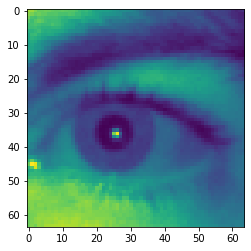

Open


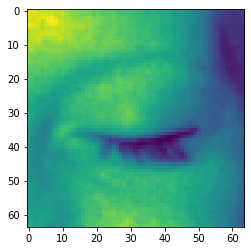

Closed


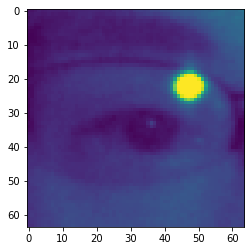

Open


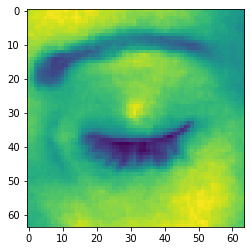

Closed


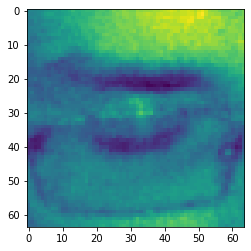

Closed


In [11]:
for i in x_test[0:5]:
    result = best_model.predict(np.expand_dims(i,0))
    plt.imshow(i)
    plt.show()
    
    if result > 0.5:
        print('Open')
    else:
        print("Closed")
    

Text(0.5, 24.0, 'Actual')

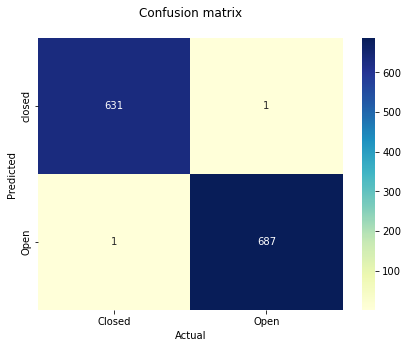

In [12]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

plt.figure(figsize=(15, 5))

preds = best_model.predict(x_test)
preds = (preds >= 0.5).astype(np.int32)
cm = confusion_matrix(y_test, preds)
df_cm = pd.DataFrame(cm, index=['closed', 'Open'], columns=['Closed', 'Open'])
plt.subplot(121)
plt.title("Confusion matrix\n")
sns.heatmap(df_cm, annot=True, fmt="d", cmap="YlGnBu")
plt.ylabel("Predicted")
plt.xlabel("Actual")